
---
title: "Conjunto de modelos"
date: 2022-04-20T10:37:29+02:00
tags: [ensemble models, bagging, bootstrap, boosting, random forest, gradient-boosting, parada temprana, early-stopping]
categories: [tutoriales]
---

En este post veremos en detalle los algoritmos que combinan varios modelos juntos, también llamados conjunto de modelos. Presentaremos dos familias de estas técnicas: (i) basados en *bootstrapping* y (ii) basados en *boosting*. Presentaremos *bagging* y *árboles aleatorios* como pertenecientes a la primera estrategia y *AdaBoost* y *árboles de decisión gradient boosting* que pertenecen a la última estrategia. Finalmente, hablaremos sobre los hiperparámetros que permiten afinar estos modelos y compararlos entre modelos.

# Ejemplo introductorio a los modelos de conjunto

En este ejemplo queremos enfatizar los beneficios de los métodos de conjunto sobre los modelos simples (por ejemplo, árbol de decisión, modelo lineal, etc.). Combinar modelos simples produce modelos más poderosos y robustos con menos problemas.

Empezaremos cargando el dataset de propiedades de California. El objetivo de este dataset es prededir el valor medio de la vivienda en algunos distritos de California basándonos en datos geofráficos y demográficos.

In [1]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
y *= 100  # reescala el objetivo en k$

Vamos a comprobar el rendimiento de generalización de un árbol de decisión regresor con los parámetros por defecto.

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)
cv_results = cross_validate(tree, X, y, n_jobs=-1)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.354 +/- 0.087


Obtenemos resultados justos. Sin embargo, ya sabemos que este modelo necesita se afinado. De hecho, los parámetros por defecto no conducen necesariamente a un árbol de decisión óptimo. En lugar de usar los valores por defecto, debemos buscar a través de validación cruzada el valor óptimo de parámetros importantes, como son `max_depth`, `min_samples_split` o `min_samples_leaf`.

Recordemos que necesitamos ajustar esos parámetros, ya que los árboles de decisión adolecen de overfitting si aumenta la profundidad del árbol, pero no existen reglas de cómo se debe configurar cada parámetro. Por tanto, no realizar una búsqueda nos llevaría a tener un modelo con underfitting u overfitting.

Ahora vamos a hacer un grid search para afinar los hiperparámetros que hemos mencionado anteriormente.

In [3]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
      "max_depth": [5, 8, None],
      "min_samples_split": [2, 10, 30, 50],
      "min_samples_leaf": [0.01, 0.05, 0.1, 1]}
cv = 3

tree = GridSearchCV(DecisionTreeRegressor(random_state=0),
                    param_grid=param_grid, cv=cv, n_jobs=-1)
cv_results = cross_validate(tree, X, y, n_jobs=-1,
                            return_estimator=True)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.523 +/- 0.107
CPU times: total: 15.6 ms
Wall time: 4.01 s


Vemos que optimizar los hiperparámetros tiene un efecto positivo en el rendimiento de generalización. Sin embargo, conlleva un alto coste computacional.

Podemos crear un dataframe almacenando la información importante recopilada durante el ajuste de hiperparámetros e investigar los resultados.

Ahora usaremos un metodo de conjunto llamado **bagging**. Brevemente, este método usará un regresor de base (es decir, árboles de decisión regresores) y entrenará varios de ellos en una versión ligeramente modificada del conjunto de entrenamiento. Luego, las predicciones de todos esos regresores base se combinarán promediando.

Aquí, usaremos 20 árboles de decisión y comprobaremos el tiempo de entrenamiento así como el rendimiento de generalización en los datos de prueba externos. Es importante notar que no vamos a ajustar ningún parámetro del árbol de decisión.

In [4]:
%%time
from sklearn.ensemble import BaggingRegressor

base_estimator = DecisionTreeRegressor(random_state=0)
bagging_regressor = BaggingRegressor(
    base_estimator=base_estimator, n_estimators=20, random_state=0)

cv_results = cross_validate(bagging_regressor, X, y, n_jobs=-1)
scores = cv_results["test_score"]

print(f"Puntuación R2 obtenida por validación cruzada: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

Puntuación R2 obtenida por validación cruzada: 0.642 +/- 0.083
CPU times: total: 31.2 ms
Wall time: 3.32 s


Sin realizar la búsqueda de los hiperparámetros óptimos, el rendimiento de generalización global del regresor bagging es mucho mejor que un único árbol de decisión. Además, el coste computacional se reduce en comparación a la búsqueda de hiperparámetros óptimos.

Esto muestra la motivación existente detrás del uso de métodos de conjunto: proporcionan una relativamente buena baseline con un rendimiento de generalización decente sin ningún ajuste de hiperparámetros.

A continuación veremos en detalle dos familias de conjunto: bagging y boosting:

+ conjunto usando bootstrap (por ejemplo, bagging y bosques aleatorios);
+ conjunto usando boosting (por ejemplo, boosting adaptativo y álboles de decisión gradient-boosting).

# Métodos de conjuntos usando bootstrapping

## Bagging

Vamos a introducir una estrategia muy natural de construir conjuntos de modelos de machine learning llamado "bagging".

"Bagging" proviene de Bootstrap AGGregatING. Utiliza remuestreo bootstrap (muestreo aleatorio con reemplazo) para aprender varios modelos en variaciones aleatorias del conjunto de entrenamiento. A la hora de predecir, se agregan las predicciones de cada aprendiz para obtener las predicciones finales.

En primer lugar, vamos a generar un dataset sintético simple para obtener información de bootstraping.

In [5]:
import pandas as pd
import numpy as np

rng = np.random.RandomState(1)

def generate_data(n_samples=30):
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

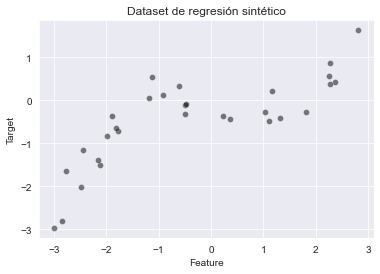

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train = generate_data(n_samples=30)
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
_ = plt.title("Dataset de regresión sintético")

La relación entre nuestras features y el objetivo a predecir es no lineal. Sin embargo, un árbol de decisión es capaz de aproximar tal dependencia no lineal:

In [7]:
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

En este caso, el término "test" se refiere a datos que no se han usado previamente para entrenar y calcular una métrica de evaluación en un conjunto de prueba de este tipo no tendría sentido.

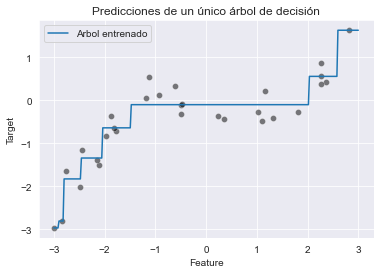

In [8]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
plt.plot(X_test["Feature"], y_pred, label="Arbol entrenado")
plt.legend()
_ = plt.title("Predicciones de un único árbol de decisión")

Veamos cómo podemos usar bottstraping para aprender varios árboles.

### Bootstrap resampling

Una muestra bootstrap corresponde a un remuestreo con reemplazo del dataset original, una muestra que tiene el mismo tamaño que el dataset original. Por lo tanto, la muestra bootstrap contendrá varias veces algunos puntos de datos, mientras que algunos de los puntos de datos originales no estarán presentes.

Crearemos una función que, dados `X` e `y`, devolverá una variación remuestreada `X_boostrap` e `y_boostrap`.

In [9]:
def bootstrap_sample(data, target):
    # indices corresponde a un muestreo con reemplazo del misma tamaño de muestra
    # que los datos originales
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

Vamos a generar 3 muestras bootstrap y verificaremos cualitativamente la diferencia con el dataset original.

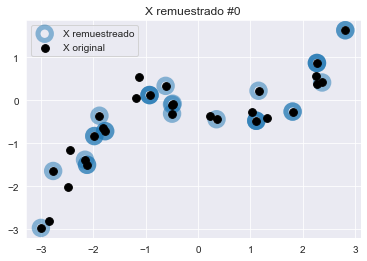

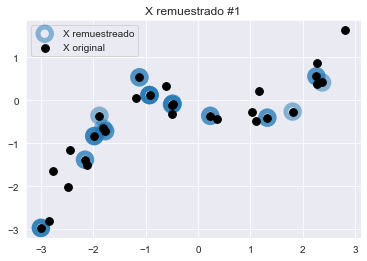

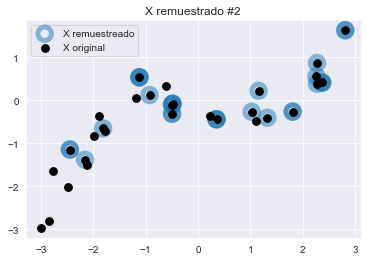

In [10]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    X_bootstrap, y_bootstrap = bootstrap_sample(
        X_train, y_train
    )
    plt.figure()
    plt.scatter(X_bootstrap["Feature"], y_bootstrap,
                color="tab:blue", facecolor="none",
                alpha=0.5, label="X remuestreado", s=180, linewidth=5)
    plt.scatter(X_train["Feature"], y_train,
                color="black", label="X original", s=60)
    plt.title(f"X remuestrado #{bootstrap_idx}")
    plt.legend()

Observemos que las tres variaciones comparten puntos comunes con el dataset original. Algunos puntos son remuestreados aleatoriamente varias veces y aparecen como círculos azul oscuro.

Las tres muestras bootstrap generadas son diferentes del dataset original y entre cada una de ellas. Para confirmar esta intuición, podemos comprobar el número de muestras únicas en las muestras bootstrap.

In [11]:
X_train_huge, X_test_huge, y_train_huge = generate_data(n_samples=100_000)
X_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(
    X_train_huge, y_train_huge)

ratio_unique_sample = (np.unique(X_bootstrap_sample).size /
                       X_bootstrap_sample.size)
print(
    f"Porcentaje de muestras presentes en el dataset original: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Porcentaje de muestras presentes en el dataset original: 63.2%


En promedio, un 63.2% de los puntos de datos del dataset original estarán presentes en una muestra bootstrap dada. El otro 36.8% son muestras repetidas. Somos capaces de generar muchos datasets, todos ligeramente diferentes.

Ahora podemos entrenar un árbol de decisión para cada uno de esos datasets y todos ellos serán también ligeramente diferentes.

In [12]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    X_bootstrap_sample, y_bootstrap_sample = bootstrap_sample(
        X_train, y_train)
    tree.fit(X_bootstrap_sample, y_bootstrap_sample)
    bag_of_trees.append(tree)

Ahora que podemos crear una bolsa de árboles diferentes, podemos usar cada uno de los tres árboles para predecir las muestras dentro del rango de los datos. Ellos proporcionarán predicciones ligeramente diferentes.

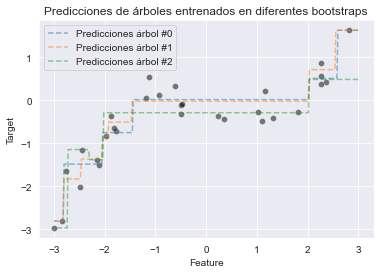

In [13]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    y_pred = tree.predict(X_test)
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.5,
             label=f"Predicciones árbol #{tree_idx}")
plt.legend()
_ = plt.title("Predicciones de árboles entrenados en diferentes bootstraps")

### Agregación

Una vez hemos entrenado nuestros árboles somos capaces de obtener predicciones de cada uno de ellos. En regresión, la forma más directa de combinar esas predicciones es promediarlas:para un punto de datos de prueba dado, alimentamos los valores de features de entrada a cada uno de los `n` models entrenados en el conjunto y, como resultado, calculamos `n` valores predichos para la variable objetivo. La predicción final del conjunto para los puntos de datos de prueba es la media de esos `n`valores.

Podemos dibujar las predicciones promediadas del ejemplo anterior.

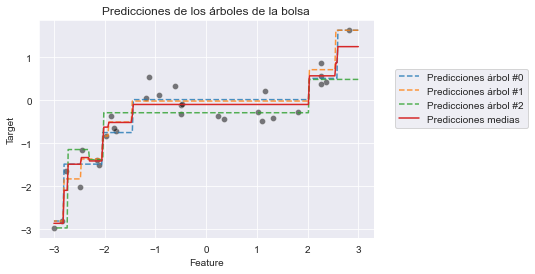

In [14]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    y_pred = tree.predict(X_test)
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.8,
             label=f"Predicciones árbol #{tree_idx}")
    bag_predictions.append(y_pred)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(X_test["Feature"], bag_predictions, label="Predicciones medias",
         linestyle="-")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicciones de los árboles de la bolsa")

La línea roja continua muestras las predicciones medias, las cuales serán las predicciones finales proporcionadas por nuestra bolsa de árboles de decisión regresores. Nótese que las predicciones de los conjuntos son más estables debido a la operación de promedio. Como resultado, el conjunto de árboles, en global, es menos probable que adolezca de overfitting que los árboles individuales.

### Bagging en scikit-learn

Scikit-learn implementa el procedimiento de bagging como un "meta-estimador", que es un estimador que recubre otro estimador: toma un modelo base que es clonado varias veces y entrenado independientemente en cada muestra bootstrap.

El siguiente fragmento de código muestra cómo construir un conjunto bagging de árboles de decisión. Establecemos `n_estimators=100` en lugar de los 3 que vimos anteriormente en la implementación manual para obtener un efecto de suavizado más fuerte.

In [15]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100
)
bagged_trees.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                 n_estimators=100)

Vamos a visualizar las predicciones del conjunto en el mismo intervalo de datos:

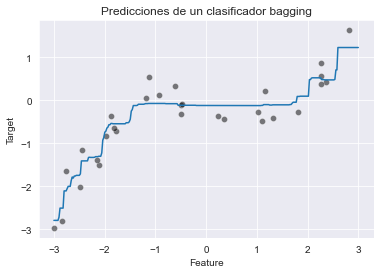

In [16]:
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagged_trees.predict(X_test)
plt.plot(X_test["Feature"], y_pred)
_ = plt.title("Predicciones de un clasificador bagging")

Debido a que hemos usado 100 árboles en el conjunto, las predicción media es ligeramente más suave pero muy similar a la del gráfico anterior. Es posible acceder después del entrenamiento a los modelos internos del conjunto almacenados como una lista de Python en el atributo `bagged_trees.estimators_`.

Comparemos las predicciones de los modelos base con sus medias:

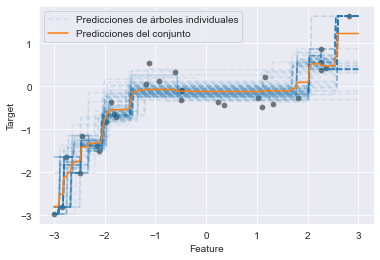

In [17]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predicciones de árboles individuales" if tree_idx == 0 else None
    # convertirmos `X_test` a un array Numpy para evitar el warning de scikit-learn
    y_pred = tree.predict(X_test.to_numpy())
    plt.plot(X_test["Feature"], y_pred, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagged_trees.predict(X_test)
plt.plot(X_test["Feature"], y_pred,
         color="tab:orange", label="Predicciones del conjunto")
_ = plt.legend()

Usamos un valor bajo del parámetro de opacidad `alpha` para apreciar mejor el solape en las funciones de predicción de los árboles individuales.

Esta visualización nos da algunas ideas sobre la incertidumbre de las predicciones en diferentes áreas del espacio de features.

### Pipelines de bagging complejos

Aunque hemos usado un árbol de decisión como modelo de base, nada nos impide que usemos cualquier otro tipo de modelo.

Como sabemos que la función de generación de los datos originales es una transformación polinomial ruidosa de la variable de entrada, intentemos entrenar un pipeline de regresión polinomial bagged en este dataset.

In [18]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

El pipeline en primer lugar escala los datos a un rango 0-1 con `MinMaxScaler`. Despupés extrae features polinomiales de grado 4. Las features resultantes permanecerán en el rango 0-1 por construcción: si `x` se encuentra en el rango 0-1, entonces `x ** n` también se encontrará en el rango 0-1 para cualquier valor de `n`.

Después el pipeline alimenta las features no lineales resultantes a un modelo de regresión lineal regularizado para la predicción final de la variable objetivo.

Nótese que se ha usado intencionadamente un valor pequeño para el parámetro de regularización `alpha`, ya que esperamos que el conjunto bagging funcione bien con modelos de base ligeramente overfitting.

El conjunto en sí mismo se construye simplemente pasando el pipeline resultante al paráemtro `base_estimator` de la clase `BaggingRegressor`:

In [19]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
bagging.fit(X_train, y_train)

BaggingRegressor(base_estimator=Pipeline(steps=[('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('polynomialfeatures',
                                                 PolynomialFeatures(degree=4)),
                                                ('ridge', Ridge(alpha=1e-10))]),
                 n_estimators=100, random_state=0)

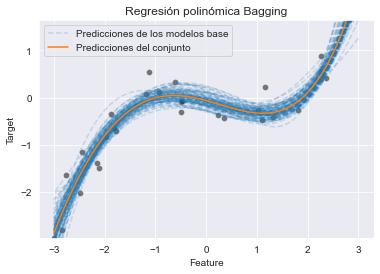

In [20]:
for i, regressor in enumerate(bagging.estimators_):
    # convertirmos `X_test` a un array Numpy para evitar el warning de scikit-learn
    regressor_predictions = regressor.predict(X_test.to_numpy())
    base_model_line = plt.plot(
        X_test["Feature"], regressor_predictions, linestyle="--", alpha=0.2,
        label="Predicciones de los modelos base" if i == 0 else None,
        color="tab:blue"
    )

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)

y_pred = bagging.predict(X_test)
plt.plot(X_test["Feature"], y_pred,
         color="tab:orange", label="Predicciones del conjunto")
plt.ylim(y_train.min(), y_train.max())
plt.legend()
_ = plt.title("Regresión polinómica Bagging")

Las predicciones de este modelo de regresión polinómica bagged parece cualitativamente mejor que los áboles bagging. Esto era algo esperado dado que el modelo de base refleja mejor nuestro conocimiento del proceso de generación de los datos verdaderos.

De nuevo las diferentes opacidades inducidas por el solapamiento de las líneas azules nos permite apreciar la incertidumbre de las predicciones en el conjunto bagged.

Nótese que el procedimiento de bootstrapping es una herramienta genérica de estadística y no está limitada a construir conjuntos de modelos de machine learning. Se puede obtener más detalle sobre este punto en el [artículo de Wikipedia sobre bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).

### Ejercicio bagging

Vamos a realizar un pequeño ejercicio de lo visto hasta ahora. Queremos investigar si podemos ajustar los hiperparámetros de un regresor bagging y evaluar la ganancia obtenida. Para ello usaremos el dataset de propiedades de California.

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
y *= 100  # rescale the target in k$
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.5)

Vamos a crear un `BaggingRegressor` y proporcionaremos un `DecisionTreeRegressor` a su parámetro `base_estimator`. Entrenaremos el regresor y evaluaremos su rendimiento de generalización en el conjunto de prueba usando el error absoluto medio.

In [22]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

bagging = BaggingRegressor(
    base_estimator=DecisionTreeRegressor())

bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

print(f"MAE del regresor bagging básico: "
      f"{mean_absolute_error(y_test, y_pred):.2f} k$")

MAE del regresor bagging básico: 35.97 k$


Ahora crearemos una instancia de `RandomizedSearchCV` usando el modelo previo y ajustando los parámetros importantes del regresor bagging. Debemos encontrar los mejores parámetros y comprobar que somos capaces de encontrar un conjunto de parámetros que mejoren el regresor por defecto, usando también como métrica el error absoluto medio.

In [23]:
# Comprobemos cuáles son los parámetros de nuestro regresor bagging
bagging.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__criterion': 'squared_error',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeRegressor(),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [24]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": randint(10, 30),
    "max_samples": [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0],
    "base_estimator__max_depth": randint(3, 10),
}

model = RandomizedSearchCV(
    bagging, param_grid, n_iter=20, scoring="neg_mean_absolute_error")
model.fit(X_train, y_train)

RandomizedSearchCV(estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor()),
                   n_iter=20,
                   param_distributions={'base_estimator__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4B835A590>,
                                        'max_features': [0.5, 0.8, 1.0],
                                        'max_samples': [0.5, 0.8, 1.0],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F4B82D9840>},
                   scoring='neg_mean_absolute_error')

In [25]:
model.best_params_

{'base_estimator__max_depth': 9,
 'max_features': 0.8,
 'max_samples': 0.8,
 'n_estimators': 25}

In [26]:
import pandas as pd

cv_results = pd.DataFrame(model.cv_results_)
cv_results.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.455792,0.006091,0.008107,3.745593e-04,9,0.8,0.8,25,"{'base_estimator__max_depth': 9, 'max_features...",-39.279991,-38.880628,-38.619408,-39.440439,-36.531615,-38.550416,1.050122,1
15,0.320576,0.000928,0.006406,2.000333e-04,8,1.0,0.5,21,"{'base_estimator__max_depth': 8, 'max_features...",-41.914622,-41.483535,-39.830309,-42.232385,-39.161815,-40.924533,1.208945,2
16,0.184759,0.002748,0.005205,2.456516e-04,7,0.8,0.5,17,"{'base_estimator__max_depth': 7, 'max_features...",-44.589440,-42.106688,-40.293463,-44.670376,-40.690151,-42.470024,1.863912,3
14,0.282943,0.004392,0.005605,2.004386e-04,7,0.8,0.8,19,"{'base_estimator__max_depth': 7, 'max_features...",-41.832809,-43.779636,-42.014627,-43.711636,-41.013014,-42.470344,1.094805,4
6,0.257421,0.002090,0.005805,2.449898e-04,7,0.8,0.8,17,"{'base_estimator__max_depth': 7, 'max_features...",-42.989436,-42.727496,-40.938417,-44.601246,-41.207918,-42.492903,1.327728,5
13,0.262926,0.002443,0.005605,2.003911e-04,7,1.0,0.5,19,"{'base_estimator__max_depth': 7, 'max_features...",-43.521755,-44.202781,-42.572490,-43.749080,-41.546292,-43.118480,0.949303,6
4,0.222692,0.001049,0.005305,2.453791e-04,6,1.0,0.5,18,"{'base_estimator__max_depth': 6, 'max_features...",-45.666625,-45.603503,-44.938197,-45.636675,-43.376790,-45.044358,0.876670,7
9,0.195368,0.001602,0.004604,1.995565e-04,6,0.8,0.8,15,"{'base_estimator__max_depth': 6, 'max_features...",-45.489748,-46.381155,-44.224186,-45.389135,-43.919159,-45.080677,0.898491,8
2,0.259023,0.002806,0.008507,2.861023e-07,9,0.5,0.5,28,"{'base_estimator__max_depth': 9, 'max_features...",-45.003335,-46.935110,-45.408900,-44.305677,-44.801457,-45.290896,0.895574,9
1,0.330484,0.000813,0.005204,2.451844e-04,6,1.0,1.0,17,"{'base_estimator__max_depth': 6, 'max_features...",-46.330157,-46.133009,-44.831581,-45.898168,-43.435013,-45.325586,1.077706,10


In [27]:
y_pred = model.predict(X_test)

print(f"MAE del regresor bagging tuneado: "
      f"{mean_absolute_error(y_test, y_pred):.2f} k$")

MAE del regresor bagging tuneado: 37.66 k$


Podemos ver que el predictor proporcionado por el regresor bagging no necesita de demasiado ajuste de hiperparámetros. No se consigue mejora con el tuneado.

## Bosque aleatorio

Vamos a presentar los modelos random forest y mostraremos las diferencias con los conjuntos bagging. Random forest es un modelo popular en machine learning. Es una modificación del algoritmo bagging. En bagging, se puede usar cualquier clasificador o regresor. En random forest, el clasificador o regresor base es siempre un árbol de decisión.

Random forest tiene otra particularidad: cuando se entrena un árbol, la búsqueda de la mejor división se realiza solo en un subconjunto de las features originales tomadas al azar. Los subconjuntos aleatorios son diferentes para cada división de nodo. El objetivo es inyectar aleatoriedad adicional en el procedimiento de aprendizaje para intentar decorrelacionar los errores predichos de los árboles individuales.

Por tanto, random forest usan aleatoriedad en ambos ejes de la matriz de datos:

+ en las muestras bootstrapping de cada árbol del bosque;
+ seleccionando aleatoriamente un subconjunto de features en cada nodo del árbol.


### Un vistazo a random forests

Ilustraremos el uso de un clasificador random forest en el dataset de censo de adultos.

In [28]:
adult_census = pd.read_csv("../data/adult_census.csv")
target_name = "class"
X = adult_census.drop(columns=[target_name, "education-num"])
y = adult_census[target_name]

El dataset de censo de adultos contiene algunas datos categóricos y codificaremos las variables categóricas usando un `OrdinalEncoder`, dado que los modelos basados en árbol pueden trabajan muy eficientemente con esta representación tan simple de variables categóricas.

Dado que existen categorías raras en este dataset necesitamos especificar la codificación de las categorías desconocidas en tiempo de predicción para que sea capaz de usar validación cruzada. De lo contrario, algunas categorías raras solo podrían estar presentes en el lado de validación de la división de validación cruzada y `OrdinalEncoder` podría lanzar un error cuando llame a su método `transform` con los puntos de datos del conjunto de validación.

In [29]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

categorial_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = make_column_transformer(
    (categorial_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough"
)

Haremos primero un ejemplo simple donde entrenaremos un único clasificador de árbol de decisión y comprobaremos su rendimiento de generalización a través de validación cruzada.

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

tree = make_pipeline(preprocessor,
                     DecisionTreeClassifier(random_state=0))

In [31]:
from sklearn.model_selection import cross_val_score

scores_tree = cross_val_score(tree, X, y)

print(f"Clasificador árbol decisión: "
      f"{scores_tree.mean():.3f} +/- {scores_tree.std():.3f}")

Clasificador árbol decisión: 0.812 +/- 0.002


De forma similar a como hemos hecho anteriormente, vamos a construir un `BaggingClassifier` con un clasificador de árbol de decisión como modelo base. Además, necesitamos especificar cuántos modelos queremos combinar. También necesitamos preprocesar los datos y, por tanto, usaremos un pipeline de scikit-learn.

In [32]:
from sklearn.ensemble import BaggingClassifier

bagged_trees = make_pipeline(
    preprocessor,
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(random_state=0),
        n_estimators=50, n_jobs=-1, random_state=0
    )
)

In [33]:
scores_bagged_trees = cross_val_score(bagged_trees, X, y)

print(f"Clasificador arbol decisión bagged: "
      f"{scores_bagged_trees.mean():.3f} +/- "
      f"{scores_bagged_trees.std():.3f}")

Clasificador arbol decisión bagged: 0.853 +/- 0.003


El rendimiento de generalización de los árboles bagged es mucho mejor que el rendimiento de un único árbol.

Ahora vamos a usar random forest. Observaremos que no necesitamos especificar ningún `base_estimator` porque el estimador se fuerza que sea un árbol de decisión. Por tanto, sólo necesitamos especificar el número deseado de árboles del bosque.

In [34]:
from sklearn.ensemble import RandomForestClassifier

random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0)
)

In [35]:
scores_random_forest = cross_val_score(random_forest, X, y)

print(f"Clasificador random forest: "
      f"{scores_random_forest.mean():.3f} +/- "
      f"{scores_random_forest.std():.3f}")

Clasificador random forest: 0.856 +/- 0.002


Parece que el rendimiento de random forest es ligeramente superior a los árboles bagged, posiblemente debido a la selección aleatoria de las variables que decorrelacionan los errores de predicción de los árboles individuales y, en consecuencia, hacen el paso de promediado más eficiente al reducir el overfitting.

### Detalles sobre los hiperparámetros por defecto

Para random forest es posible controlar la cantidad de aleatoriedad para cada división estableciendo el valor del hiperparámetro `max_features`:

+ `max_features=0-5` significa que se considerarán el 50% de las features en cada división;
+ `max_features=1.0` significa que se considerarán todas las features en cada división, lo que realmente deshabilita el submuestreo de features.

Por defecto, `RandomForestRegressor` deshabilita el submuestreo de features mientras que `RandomForestClassifier` usa `max_features=np.sqrt(n_features)`. Estos valores por defecto reflejan buenas prácticas dadas en la literatura científica.

Sin embargo, `max_features` es uno de los hiperparámetros a tener en consideración cuando se ajusta un random forest:

+ demasiada aleatoriedad en los árboles puede conducir a modelos base con underfitting y puede ir en detrimento del conjunto en su totalidad,
+ muy poca aleatoriedad en los árboles conduce a mayor correlación de los errores de predicción y, como resultado, a reducir los beneficios del paso de promediado en términos de control del overfitting.

En scikit-learn, las clases bagging también exponen un parámetro `max_features`. Sin embargo, `BaggingClassifier` y `BaggingRegressor` son agnósticos respecto al sus modelos base y, por tanto, el submuestro de features aleatorio solo puede producirse una vez antes de entrenar cada modelo base, en lugar de varias veces por modelo base como es el caso cuando se añaden divisiones a un árbol dado.

Se pueden resumir estos detalles en la siguiente tabla:

| Clase modelo de conjunto | Clase modelo base                   | Valor por defecto para `max_features` | Estrategia de submuestreo de features |
|--------------------------|-------------------------------------|---------------------------------------|---------------------------------------|
| `BaggingClassifier`      | especificado por usuario (flexible) | `n_features` (sin submuestreo)        | Nivel de modelo                       |
| `RandomForestClassifier` | `DecisionTreeClassifier`            | `sqrt(n_features)`                    | Nivel de nodo de árbol                |
| `BaggingRegressor`       | especificado por usuario (flexible) | `n_features` (sin submuestreo)    | Nivel de modelo                       |
| `RandomForestRegressor`  | `DecisionTreeRegressor`             | `n_features` (sin submuestreo)    | Nivel de nodo de árbol                |

### Ejercicio random forest

Vamos a realizar un pequeño ejercicio de random forest. El objetivo es explorar algunos atributos disponibles en random forest de scikit-learn. Vamos a usar el dataset de regresión de pingüinos.

In [36]:
from sklearn.model_selection import train_test_split

penguins = pd.read_csv("../data/penguins_regression.csv")
feature_name = "Flipper Length (mm)"
target_name = "Body Mass (g)"
X, y = penguins[[feature_name]], penguins[target_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

Crearemos un random forest conteniendo 3 árboles. Entrenaremos el bosque y comprobaremos el rendimiento de generalización en el conjunto de prueba en términos de error absoluto medio.

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

random_forest = RandomForestRegressor(n_estimators=3, n_jobs=-1,
                                      random_state=0)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f} g")

MAE: 345.349 g


Lo siguiente que haremos será:

+ crear un dataset que contenga los pinguinos con un tamaño de aleta entre 170 mm y 230 mm,
+ dibujar los datos de entrenamiento usando un scatter plot,
+ dibujar la decisión de cada árbol individual prediciendo en el recién creado dataset,
+ dibujar la decisión del random forest usando este recién creado dataset.

In [38]:
data_range = pd.DataFrame(np.linspace(170, 235, num=300),
                          columns=X.columns)
tree_preds = []
for tree in random_forest.estimators_:
    tree_preds.append(tree.predict(data_range.to_numpy()))

random_forest_preds = random_forest.predict(data_range)

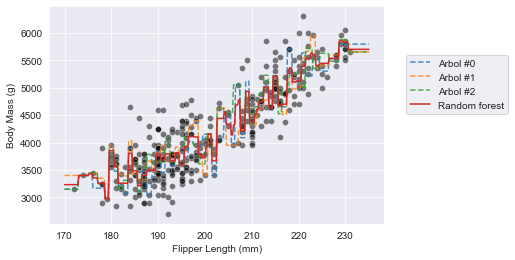

In [39]:
sns.scatterplot(data=penguins, x=feature_name, y=target_name,
                color="black", alpha=0.5)

# Dibuja las predicciones de los árboles
for tree_idx, predictions in enumerate(tree_preds):
    plt.plot(data_range[feature_name], predictions, label=f"Arbol #{tree_idx}",
             linestyle="--", alpha=0.8)

plt.plot(data_range[feature_name], random_forest_preds, label=f"Random forest")
_ = plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")

# Conjuntos basados en boosting

## Boosting adaptativo (AdaBoost)

Vamos a presentar el algoritmos Boosting Adaptativo (AdaBoost). El objetivo es obtener información observando la maquinaria interna de AdaBoots y boosting en general.

Cargaremos el dataset de pingüinos y predeciremos su especie a partir de las features de longitud y anchura del pico.

In [40]:
penguins = pd.read_csv("../data/penguins_classification.csv")
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"
X, y = penguins[culmen_columns], penguins[target_column]

Entrenaremos un árbol de decisión poco profundo intencionadamente. Dada su poca profundidad, es poco probable que tenga overfitting y algunas de las muestras de entrenamiento incluso serán mal clasificadas.

In [41]:
from sklearn.tree import DecisionTreeClassifier

palette = ["tab:red", "tab:blue", "black"]

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=0)

Podemos predecir en el mismo dataset y comprobar qué muestras están mal clasificadas.

In [42]:
y_pred = tree.predict(X)
misclassified_samples_idx = np.flatnonzero(y != y_pred)
X_misclassified = X.iloc[misclassified_samples_idx]

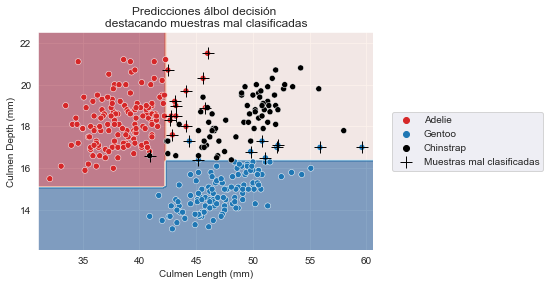

In [43]:
from helpers.plotting import DecisionBoundaryDisplay

DecisionBoundaryDisplay.from_estimator(
    tree, X, response_method="predict", cmap="RdBu", alpha=0.5
)

# dibuja el dataset original
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# Dibuja los ejemplos mal clasificados
sns.scatterplot(data=X_misclassified, x=culmen_columns[0],
                y=culmen_columns[1], label="Muestras mal clasificadas",
                marker="+", s=150, color="k")

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Predicciones álbol decisión \ndestacando muestras mal "
              "clasificadas")

Observamos que hay varios ejemplos que han sido mal clasificados por el clasificador.

Mencionamos que boosting se basa en la creación de un nuevo clasificador que intenta corregir esas clasificaciones erróneas. En scikit-learn, los aprendices tiene un parámetro `sample_weight` que fuerza a prestar más atención a los ejemplos con pesos altos durante el entrenamiento.

Este parámetro se establece cuando se llama a `classifier.fit(X, y, sample_weight=weights)`. Usaremos este truco para crear un nuevo clasificador "descartando" todas las muestras clasificadas correctamente y considerando únicamente las mal clasificadas. Así, a las muestras mal clasificadas se asigará un peso de 1 y a las bien clasificadas un peso de 0.

In [44]:
sample_weight = np.zeros_like(y, dtype=int)
sample_weight[misclassified_samples_idx] = 1

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X, y, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

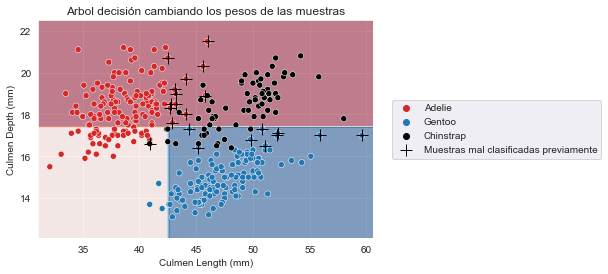

In [45]:
DecisionBoundaryDisplay.from_estimator(
    tree, X, response_method="predict", cmap="RdBu", alpha=0.5
)
sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
sns.scatterplot(data=X_misclassified, x=culmen_columns[0],
                y=culmen_columns[1],
                label="Muestras mal clasificadas previamente",
                marker="+", s=150, color="k")

plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Arbol decisión cambiando los pesos de las muestras")

Vemos que la función de decisión ha cambiado drásticamente. Cualitativamente vemos que los ejemplos que previamente estaban mal clasificados ahora son clasificados correctamente.

In [46]:
y_pred = tree.predict(X)
newly_misclassified_samples_idx = np.flatnonzero(y != y_pred)
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

print(f"Número de muestras mal clasificadas previamente y "
      f"todavía mal clasificadas: {len(remaining_misclassified_samples_idx)}")

Número de muestras mal clasificadas previamente y todavía mal clasificadas: 0


Sin embargo, estamos cometiendo errores en muestras bien clasificadas previamente. Por tanto, tenemos la intuición de que debemos ponderar las predicciones de cada clasificador de forma diferente, muy probablemente utilizando el número de errores que comete cada clasificador.

Entonces podríamos usar el error de clasificación para combinar ambos árboles.

In [47]:
ensemble_weight = [
    (y.shape[0] - len(misclassified_samples_idx)) / y.shape[0],
    (y.shape[0] - len(newly_misclassified_samples_idx)) / y.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

El primer clasificador tiene una precisión del 93,5% y el segundo una precisión de 69,2%. Por lo tanto, cuando predecimos una clase, debemos confiar un poco más en el primer clasificador que en el segundo. Podríamos usar estos valores de precisión para ponderar las predicciones de cada aprendiz.

Para resumir, boosting aprende varios clasificadores, cada uno de los cuales se enfocará más o menos en muestras específicas del dataset. Boosting es, por tanto, diferente de bagging: aquí nunca se remuestrea nuestro dataset, solo asignamos pesos diferentes al dataset original.

Boosting requiere alguna estrategia para combinar los aprendizes juntos:

+ necesita definir una forma de calcular los pesos que serán asignados a las muestras;
+ necesita asignar un peso a cada aprendiz al hacer predicciones.

De hecho, definimos un esquema realmente simple para asignar pesos a las muestras y pesos a los aprendices. Sin embargo, existen teorías estadísticas (como en AdaBoost) sobre cómo se deben calcular óptimamente estos pesos.

Usaremos el clasificador AdaBoots implementado en scikit-learn y revisaremos los clasificadores de árbol de decisión entrenados subyacentes.

In [48]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(base_estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
adaboost.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

<Figure size 432x288 with 0 Axes>

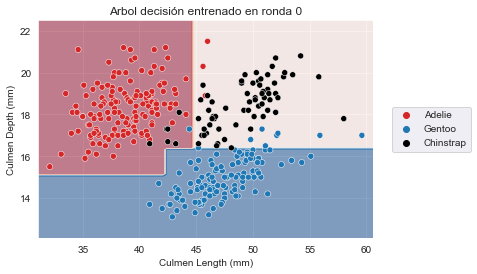

<Figure size 432x288 with 0 Axes>

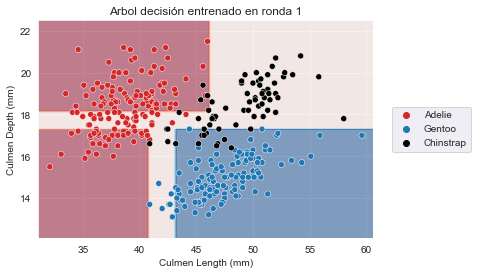

<Figure size 432x288 with 0 Axes>

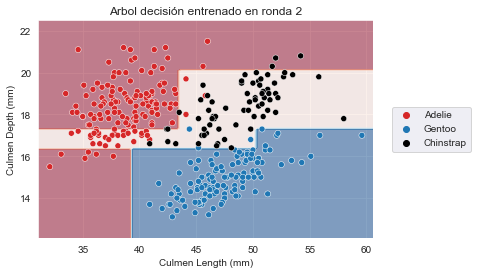

In [49]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    # covertimos "X" en un array Numpy para eviar el warning lanzado por scikit-learn
    DecisionBoundaryDisplay.from_estimator(
        tree, X.to_numpy(), response_method="predict", cmap="RdBu", alpha=0.5
    )
    sns.scatterplot(x=culmen_columns[0], y=culmen_columns[1],
                    hue=target_column, data=penguins,
                    palette=palette)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    _ = plt.title(f"Arbol decisión entrenado en ronda {boosting_round}")

In [50]:
print(f"Peso de cada clasificador: {adaboost.estimator_weights_}")

Peso de cada clasificador: [3.58351894 3.46901998 3.03303773]


In [51]:
print(f"Error de cada clasificador: {adaboost.estimator_errors_}")

Error de cada clasificador: [0.05263158 0.05864198 0.08787269]


Vemos que AdaBoost ha aprendido tres clasificadores diferentes, cada uno de los cuales se enfoca en muestras diferentes. Revisando los pesos de cada aprendiz, vemos que el conjunto ofrece el mayor peso al primer clasificador. Esto de hecho tiene sentido cuando revisamos los errores de cada clasificador. El primer clasificador también obtiene la clasificación más alta en rendimiento de generalización.

Aunque que AdaBoost es un buen algoritmo para demostrar la maquinaria interna de los algoritmos de boosting, no es el más eficiente. Este título se otorga al algoritmo de árbol de decisión gradient-boosting (GBDT).

## Arbol de decisión gradient-boosting (GBDT)

Vamos a ver el algoritmo de árbol de decisión gradient boosting y lo compararemos con AdaBoost.

Gradient-boosting difiere de AdaBoost en lo siguiente: en lugar de asignar pesos a muestras específicas, GBDT entrenará un árbol de decisión en los errores residuales (de ahí el nombre "gradiente") del árbol anterior. Por lo tanto, cada nuevo árbol del conjunto predice el error cometido por el anterior en lugar de predecir directamente el objetivo.

Vamos a proporcionar algunas intuiciones sobre la forma en que se combinan los aprendices para proporcionar la predicción final.

In [52]:
import pandas as pd
import numpy as np

# Crea un generador de número aleatorio que utilizaremos para establecer la aleatoriedad
rng = np.random.RandomState(0)

def generate_data(n_samples=50):
    """Genera dataset sintético. Devuelve `X_train`, `X_test`,
    `y_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    X_train = pd.DataFrame(x, columns=["Feature"])
    X_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    y_train = pd.Series(y, name="Target")

    return X_train, X_test, y_train


X_train, X_test, y_train = generate_data()

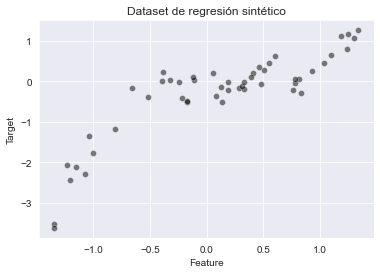

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
_ = plt.title("Dataset de regresión sintético")

Como vimos anteriormente, boosting se basa en ensamblar una secuencia de aprendices. Empezaremos creando un regresor de arbol de decisión. Estableceremos la profundidad del árbol para que el aprendiz resultante produzca underfitting.

In [54]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

Usamos el término "test" para referirnos a datos que no se han usado para el entrenamiento. No debemos confundirlo con datos provenientes de una división entrenamiento-prueba, ya que se generó en intervalos espaciados equitativamente para la evaluación visual de las predicciones.

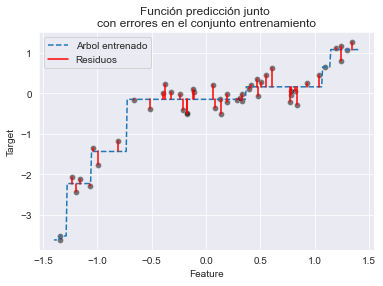

In [55]:
# dibuja los datos
sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
# dibuja las predicciones
line_predictions = plt.plot(X_test["Feature"], y_test_pred, "--")

# dibuja los residuos
for value, true, predicted in zip(X_train["Feature"],
                                  y_train,
                                  y_train_pred):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Arbol entrenado", "Residuos"])
_ = plt.title("Función predicción junto \ncon errores en el conjunto entrenamiento")

Hemos editado manualmente la leyenda para obtener solo una única etiqueta para todas las líneas de residuos.

Dado que el arbol tiene underfit, su precisión está lejos de la perfección en los datos de entrenamiento. Podemos observar esto en el gráfico viendo las diferencias entre las predicciones y los datos reales. Estos errores, llamados residuos, se presentan mediante líneas rojas continuas.

De hecho, nuestro árbol inicial no era suficientemente expresivo para manejar la complejidad de los datos, como muestran los residuos. En un algoritmo grandient-boosting, la idea es crear un segundo árbol que, dados los mismos datos `X`, intentará predecir los residuos en lugar del vector `y`. Tendríamos, por tanto, un árbol que es capaz de predecir los errores que comete el árbol inicial.

Vamos a entrenar un árbol tal.

In [56]:
residuals = y_train - y_train_pred

tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
tree_residuals.fit(X_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(X_train)
target_test_predicted_residuals = tree_residuals.predict(X_test)

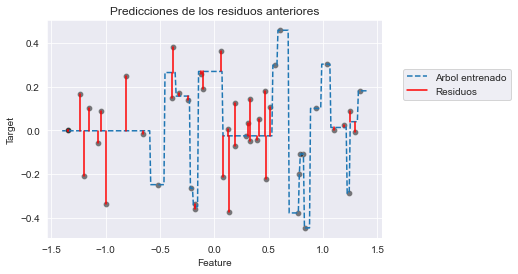

In [57]:
sns.scatterplot(x=X_train["Feature"], y=residuals, color="black", alpha=0.5)
line_predictions = plt.plot(
    X_test["Feature"], target_test_predicted_residuals, "--")

# dibuja los residuos de los residuos predichos
for value, true, predicted in zip(X_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Arbol entrenado", "Residuos"], bbox_to_anchor=(1.05, 0.8),
           loc="upper left")
_ = plt.title("Predicciones de los residuos anteriores")

Vemos que este nuevo árbol solo logra manejar algunos de los residuos. Nos enfocaremos en una muestra específica del conjunto de entrenamiento (es decir, sabemos que la muestra será bien predicha usando dos árbole sucesivos). Usaremos este ejemplo para explicar cómo se combinan las predicciones de ambos árboles. Primero seleccionaremos esta muestra en `X_train`.

In [58]:
sample = X_train.iloc[[-2]]
x_sample = sample['Feature'].iloc[0]
target_true = y_train.iloc[-2]
target_true_residual = residuals.iloc[-2]

Vamos a dibujar la información previa y destacaremos nuestra muestra. Empezaremos dibujando los datos original y la predicción del primer árbol de decisión.

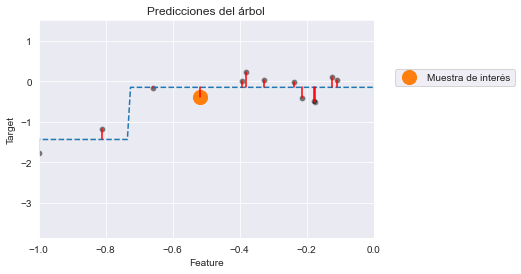

In [59]:
# Dibuja la información previa:
#   * el dataset
#   * las predicciones
#   * los residuos

sns.scatterplot(x=X_train["Feature"], y=y_train, color="black",
                alpha=0.5)
plt.plot(X_test["Feature"], y_test_pred, "--")
for value, true, predicted in zip(X_train["Feature"],
                                  y_train,
                                  y_train_pred):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Destacamos la muestra de interés
plt.scatter(sample, target_true, label="Muestra de interés",
            color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predicciones del árbol")

Ahora dibujaremos la información de los residuos. Dibujaremos los residuos calculados por el primer árbol de decisión y mostraremos las predicciones de residuos.

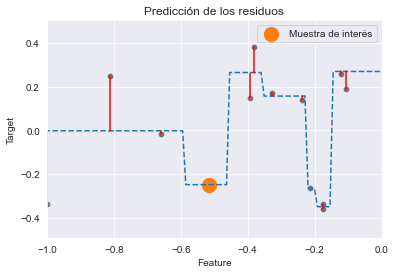

In [60]:
# Dibuja la información previa:
#   * los residuso cometidos por el primer árbol
#   * las predicciones de residuos
#   * los residuos de las predicciones de residuos

sns.scatterplot(x=X_train["Feature"], y=residuals,
                color="black", alpha=0.5)
plt.plot(X_test["Feature"], target_test_predicted_residuals, "--")
for value, true, predicted in zip(X_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Destaca la muestra de interés
plt.scatter(sample, target_true_residual, label="Muestra de interés",
            color="tab:orange", s=200)
plt.xlim([-1, 0])
plt.legend()
_ = plt.title("Predicción de los residuos")

Para nuestra muestra de interés, nuestro árbol inicial cometía un error (residuo pequeño). Cuando entrenamos el segundo árbol, en este caso el residuo se entrena y se predice perfectamente. Verificaremos cuantitativamente esta predicción usando el árbol entrenado. Primero, verificaremos la predicción de árbol inicial y compararemos con su valor real.

In [61]:
print(f"El valor real a predecir para "
      f"f(x={x_sample:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict(sample)[0]
print(f"Predicción del primer árbol de decisión para x={x_sample:.3f}: "
      f"y={y_pred_first_tree:.3f}")
print(f"Error del árbol: {target_true - y_pred_first_tree:.3f}")

El valor real a predecir para f(x=-0.517) = -0.393
Predicción del primer árbol de decisión para x=-0.517: y=-0.145
Error del árbol: -0.248


Como observamos visualmente, tenemos un pequeño error. Ahora, usaremos el segundo árbol para intentar predecir este residuo.

In [62]:
print(f"Predicción del residuo para x={x_sample:.3f}: "
      f"{tree_residuals.predict(sample)[0]:.3f}")

Predicción del residuo para x=-0.517: -0.248


Vemos que nuestro segundo árbol es capaz de predecir el residuo exacto (error) de nuestro primer árbol. Por tanto, podemos predecir el valor de `x` sumando la predicción de todos los árboles del conjunto.

In [63]:
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict(sample)[0]
)
print(f"Predicción del primer y segundo árbol de decisión combinados para "
      f"x={x_sample:.3f}: y={y_pred_first_and_second_tree:.3f}")
print(f"Error del árbol: {target_true - y_pred_first_and_second_tree:.3f}")

Predicción del primer y segundo árbol de decisión combinados para x=-0.517: y=-0.393
Error del árbol: 0.000


Elegimos una muestra para la cual solo fueron suficientes dos árboles para hacer una predicción perfecta. Sin embargo, vimos anteriormente en el gráfico anterior que dos árboles no son suficientes para corregir los residuos de todas las muestras. Por tanto, se necesita añadir varios árboles al conjunto para corregir adecuadamente el error (es decir, el segundo árbol corrige el error del primer árbol, mientras que el tercer árbol corrige los errores del segundo árbol y así sucesivamente).

Compararemos el rendimiento de generalización de random forest y gradient boosting en el dataset de propiedades de California.

In [64]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_validate

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100  # reescala el objetivo a k$

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, X, y, scoring="neg_mean_absolute_error",
    n_jobs=-1
)

In [66]:
print("Arbol decisión gradient boosting")
print(f"Error absoluto medio a través de validación cruzada: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{-cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Tiempo de entrenamiento medio: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Tiempo de puntuación medio: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Arbol decisión gradient boosting
Error absoluto medio a través de validación cruzada: 46.408 +/- -2.907 k$
Tiempo de entrenamiento medio: 6.463 seconds
Tiempo de puntuación medio: 0.008 seconds


In [67]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=-1)
cv_results_rf = cross_validate(
    random_forest, X, y, scoring="neg_mean_absolute_error",
    n_jobs=-1
)

In [68]:
print("Random forest")
print(f"Error absoluto medio a través de validación cruzada: "
      f"{-cv_results_rf['test_score'].mean():.3f} +/- "
      f"{-cv_results_rf['test_score'].std():.3f} k$")
print(f"Tiempo de entrenamiento medio: "
      f"{cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Tiempo de puntuación medio: "
      f"{cv_results_rf['score_time'].mean():.3f} seconds")

Random forest
Error absoluto medio a través de validación cruzada: 46.510 +/- -4.689 k$
Tiempo de entrenamiento medio: 7.761 seconds
Tiempo de puntuación medio: 0.216 seconds


En términos de rendimiento computacional, el bosque se puede paralelizar, beneficiándose del uso de múltiples cores de CPU. En términos de rendimiento de puntuación, ambos alboritmos conducen a resultados muy cercanos.

Sin embargo, vemos que gradient boosting es un algoritmo muy rápido para predecir comparado con random forest. Esto se debe al hecho de que gradient boosting usa árboles poco profundos.

## Ejercicio de boosting

Vamos a realizar un ejercicio donde verificaremos si un random forest o un árbol de decisión gradient boosting producen overfitting si el número de estimadores no se elige apropiadamente. Usaremos la estrategia de parada temprana (*early-stopping*) para evitar añadir innecesariamente árboles, para obtener los mejores rendimientos de generalización.

Para conducir nuestro experimento, usaremos el dataset de propiedades de California.

In [69]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100  # reescala el objetivo a k$
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.5)

Vamos a crear un árbol de decisión gradient-boosting con `max_depth=5` y `learning_rate=0.5`.

In [70]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(max_depth=5, learning_rate=0.5)

También crearemos un random forest con árboles completamente desarrollados estableciendo `max_depth=None`.

In [71]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(max_depth=None)

Para ambos modelos, crearemos una curva de validación usando el conjunto de entrenamiento para comprobar el impacto del número de árboles en el rendimiento de cada modelo. Evaluaremos la lilsta de parámetros `param_range = [1, 2, 5, 10, 20, 50, 100]` y usaremos el error absoluto medio.

In [72]:
from sklearn.model_selection import validation_curve

param_range = [1, 2, 5, 10, 20, 50, 100]

gradient_boosting_train_scores, gradient_boosting_val_scores = validation_curve(
    gradient_boosting,
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
gradient_boosting_train_errors, gradient_boosting_val_errors = -gradient_boosting_train_scores, -gradient_boosting_val_scores

random_forest_train_scores, random_forest_val_scores = validation_curve(
    random_forest,
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
random_forest_train_errors, random_forest_val_errors = -random_forest_train_scores, -random_forest_val_scores

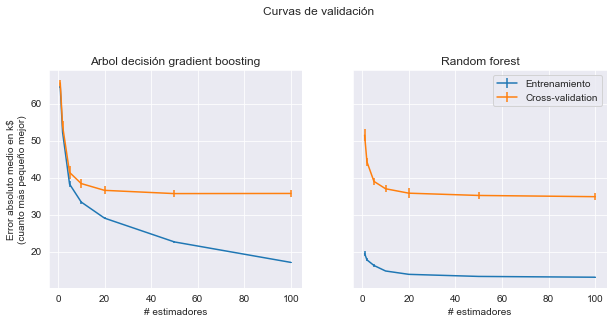

In [73]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 4))

axs[0].errorbar(
    param_range,
    gradient_boosting_train_errors.mean(axis=1),
    yerr=gradient_boosting_train_errors.std(axis=1),
    label="Entrenamiento",
)
axs[0].errorbar(
    param_range,
    gradient_boosting_val_errors.mean(axis=1),
    yerr=gradient_boosting_val_errors.std(axis=1),
    label="Validación cruzada",
)
axs[0].set_title("Arbol decisión gradient boosting")
axs[0].set_xlabel("# estimadores")
axs[0].set_ylabel("Error absoluto medio en k$\n(cuanto más pequeño mejor)")

axs[1].errorbar(
    param_range,
    random_forest_train_errors.mean(axis=1),
    yerr=random_forest_train_errors.std(axis=1),
    label="Entrenamiento",
)
axs[1].errorbar(
    param_range,
    random_forest_val_errors.mean(axis=1),
    yerr=random_forest_val_errors.std(axis=1),
    label="Cross-validation",
)
axs[1].set_title("Random forest")
axs[1].set_xlabel("# estimadores")

plt.legend()
_ = fig.suptitle("Curvas de validación", y=1.1)

Tanto gradient boosting como random forest mejorarán siempre cuando se incrementa el número de árboles del conjunto. Sin embargo, se alcanza una meseta donde añadir nuevos árboles solo provoca que se ralentice el entrenamiento y el tiempo de puntuación.

Para evitar añadir nuevos árboles innecesariamente, a diferencia de random forest, gradient boosting ofrece una opción de parada temprana. Internamente, el algoritmo usará un conjunto externo de muestras para calcular el rendimiento de generalización del modelo en cada adicción de un arbol. Por tanto, si el rendimiento de generalización no mejora en varias iteraciones, dejará de agregar árboles.

Ahora, crearemos un modelo gradient boosting con `n_estimators=1_000`. Este número de árboles será demasiado grande. Cambiaremos el parámetro `n_iter_no_change` de forma que gradrient boosting detendrá el entrenamiento tras añadir 5 árboles sin obtener mejora en el rendimiento de generalización global.

In [74]:
gradient_boosting = GradientBoostingRegressor(n_estimators=1_000, n_iter_no_change=5)
gradient_boosting.fit(X_train, y_train)
gradient_boosting.n_estimators_

127

Vemos que el número de árboles usados está bastante por debajo de 1000 con el dataset actual. Entrenar el modelo gradient boosting con el total de 1000 árboles hubiera sido inútil.

Vamos a estimar otra vez el rendimiento de generalización de este modelo usando la métrica `sklearn.metrics.mean_absolute_error`, pero esta vez usando el conjunto de prueba y compararemos el valor resultante con los valores observados en la curva de validación.

In [75]:
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(y_test, gradient_boosting.predict(X_test))
print(f"De media, nuestro regresor Gradient Boosting tiene un error de {error:.2f} k$")

De media, nuestro regresor Gradient Boosting tiene un error de 36.58 k$


Observamos que la medida del MAE en el conjunto de prueba está cercano al error de validación medido en el lado derecho de la curva de validación. Esto es tranquilizador, ya que significa que tanto el procedimiento de validación cruzada como la división externa entrenamiento-prueba coincide aproximadamente como aproximaciones al rendimiento de generalización verdadero del modelo. Podemos observar que la evaluación final del error de prueba parece estar incluso ligeramente por debajo de las puntuaciones de prueba de validación cruzada. Esto puede explicarse porque el modelo final ha sido entrenado en el conjunto completo de entrenamiento mientras que los modelos de validación cruzada han sido entrenamos en subconjuntos más pequeños: en general, cuanto mayor sea el número de puntos de entrenamiento, menor es el error de prueba.

## Acelerando gradient boosting

Vamos a presentar una versión modificada de gradient boosting que usa un número reducido de divisiones cuando construye los diferentes árboles. Este algoritmo se denomina "histogram gradient boosting" en scikit-learn.

Hemos mencionado anteriormente que random forest es un eficiente algoritmo dado que los árboles del conjunto se pueden entrenar al mismo tiempo de forma independiente. Por tanto, el algoritmo escala eficientemente tanto con el número de cores como con el número de muestras.

En gradient boosting, el algoritmo es secuencial. Requiere `N-1` árboles entranados para ser capaz de entrenar el árbol de la fase `N`. Por tanto, el algoritmo es bastante costoso desde el punto de vista computacional. La parte más costosa es la búsqueda de la mejor división del árbol que se realiza con un enfoque de fuerza bruta: se evalúan todas las posibles divisiones y se elige la mejor.

Para acelerar el algoritmo gradient boosting, podríamos reducir el número de divisiones a evaluar. Como consecuencia, el rendimiento de generalización de un árbol de este tipo también se reduciría. Sin embargo, daod que tenemos varios árboles combinados en gradient boosting, podemos añadir más estimadores para superar este problema.

Realizaremos una implementación simple de este algoritmo construyendo bloques de scikit-learn. En primer lugar, cargemos el dataset de propiedades de California.

In [76]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100  # reescala el objetivo en k$

Vamos a realizar una rápida comparativa del gradient boosting original.

In [77]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)
cv_results_gbdt = cross_validate(
    gradient_boosting, X, y, scoring="neg_mean_absolute_error",
    n_jobs=-1
)

In [78]:
print("Arbol Decisión Gradient Boosting")
print(f"Error absoluto medio via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Arbol Decisión Gradient Boosting
Error absoluto medio via cross-validation: 46.407 +/- 2.908 k$
Average fit time: 6.512 seconds
Average score time: 0.008 seconds


Recordemos que una forma de acelerar gradient boosting es reducir el número de divisiones a considerar dentro de la estructura del árbol. Una forma es agrupar los datos antes de pasarlos a gradient boosting. Un transformador llamado `KBinsDiscretizer` se encarga de tal transformación. Por lo tanto, podemos usar un pipeline para este preprocesamiento de gradient boosting.

En primer lugar, vamos a desmostrar la transformación realizada por `KBinsDiscretizer`.

In [79]:
import numpy as np

from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(
    n_bins=256, encode="ordinal", strategy="quantile")
X_trans = discretizer.fit_transform(X)
X_trans

C:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Program Files\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(


array([[249.,  39., 231., ...,  83., 162.,  30.],
       [248.,  19., 203., ...,  28., 161.,  30.],
       [242.,  49., 249., ..., 125., 160.,  29.],
       ...,
       [ 17.,  15., 126., ...,  49., 200.,  82.],
       [ 23.,  16., 136., ...,  29., 200.,  77.],
       [ 53.,  14., 130., ...,  93., 199.,  81.]])

El código anterior generará una serie de alertas. De hecho para algunas features, solicitamos demasiados contenedores (bins) con respecto a la dispersión de los datos para dichas features. Los pequeños contenedores se eliminarán.

Vemos que *discretizer* transforma los datos originales en valores enteros (aunque estén codificados usando una representación de coma flotante). Cada valor representa el índice de contenedor cuando se realiza la distribución por cuantiles. Podemos verificar el número de contenedores por feature.

In [80]:
[len(np.unique(col)) for col in X_trans.T]

[256, 50, 256, 253, 256, 256, 207, 235]

Después de la transformación, vemos que tenemos una mayoría de 256 valores únicos por feature. Ahora, usaremos el transformador para discretizar los datos antes del entrenamiento del regresor gradient boosting.

In [81]:
from sklearn.pipeline import make_pipeline

gradient_boosting = make_pipeline(
    discretizer, GradientBoostingRegressor(n_estimators=200))
cv_results_gbdt = cross_validate(
    gradient_boosting, X, y, scoring="neg_mean_absolute_error",
    n_jobs=-1
)

In [82]:
print("Arbol Decisión Gradient Boosting con KBinsDiscretizer")
print(f"Error absoluto medio via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Arbol Decisión Gradient Boosting con KBinsDiscretizer
Error absoluto medio via cross-validation: 46.130 +/- 2.230 k$
Average fit time: 4.108 seconds
Average score time: 0.010 seconds


Vemos que el tiempo de entrenamiento se ha reducido, pero el rendimiento de generalización del modelo es muy parecido. Scikit-learn proporciona clases específicas que están aún más optimizadas para grandes datasets, llamadas `HistGradientBoostingClassifier` y `HistGradientBoostingRegressor`. Cada feature del dataset `X` se agrupa primero calculando los histogramas, que se usarán posteriormente para evaluar potenciales divisiones. En número de divisiones a evaluar es entonces mucho más pequeño. Este algoritmo se convierte en mucho más eficiente que le gradient boosting cuando el dataset tiene más de 10.000 muestras.

Vamos a dar un ejemplo de dataset grande y compararemos los tiempos de cálculo con el experimento anterior.

In [83]:
from sklearn.ensemble import HistGradientBoostingRegressor

histogram_gradient_boosting = HistGradientBoostingRegressor(
    max_iter=200, random_state=0)
cv_results_hgbdt = cross_validate(
    histogram_gradient_boosting, X, y,
    scoring="neg_mean_absolute_error", n_jobs=-1,
)

In [84]:
print("Arbol Decisión Histogram Gradient Boosting")
print(f"Error absoluto medio via cross-validation: "
      f"{-cv_results_hgbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_hgbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_hgbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_hgbdt['score_time'].mean():.3f} seconds")

Arbol Decisión Histogram Gradient Boosting
Error absoluto medio via cross-validation: 43.758 +/- 2.694 k$
Average fit time: 1.000 seconds
Average score time: 0.062 seconds


El histogram gradient boosting es el mejor algoritmo en términos de puntuación. También escala cuando el número de muestras incrementa, mientras que el gradient boosting normal no.

# Ajuste de hiperparámetros con métodos de conjunto

## Random Forest

El principal parámetro de random forest que hay que ajustar es el parámetro `n_estimators`. En general, cuantos más árboles en el bosque, mejor será el rendimiento de generalización. Sin embargo, se ralentizarán los tiempos de entrenamiento y predicción. El objetivo es balancear el tiempo de cálculo y el rendimiento de generalización al establecer el número de estimadores cuando se ponga en producción.

Luego podríamos ajustar también un parámetro que controla la profundidad de cada árbol del bosque. Dos parámetros son los importantes para esto: `max_depth` y `max_leaf_nodes`. Difieren en la forma en que controlan la estructura del árbol. `max_depth` obliga a tener un árbol más simétrico, mientras que `max_leaf_nodes` no impone tal restricción.

Tengamos en cuenta que con random forest los árboles son generalmente profundos, dado que se busca overfitting en cada árbol de cada muestra bootstrap porque esto será mitigado al combinarlos todos juntos. El ensamblaje de árboles con underfitting (es decir, árboles poco profundos) también podría conducir a bosques con underfitting.

In [85]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100  # reescala en k$
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

In [86]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
}
search_cv = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=10, random_state=0, n_jobs=-1,
)
search_cv.fit(X_train, y_train)

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,mean_test_error,std_test_error
0,500,100,40.785932,0.704460
2,10,100,41.661666,0.991435
7,100,50,43.925528,0.767559
8,1,100,47.130459,0.846356
6,50,20,49.303910,0.822624
1,100,20,49.483635,0.835842
9,10,20,50.097904,0.558017
3,500,10,54.572481,0.776725
4,5,5,61.592333,0.943317
5,5,2,72.811144,0.945929


Podemos observar en nuestra búsqueda que estamos obligados a tener un número alto de hojas y, por tanto, árboles profundos. Este parámetro parece particularmente impactante en comparación con el número de árboles para este dataset en particular: con al menos 50 árboles, el rendimiento de generalización será conducido por el número de hojas.

Ahora estimaremos el rendimiento de generalización del mejor modelo reentrenandolo con el conjunto de entrenamiento completo y usando el conjunto de prueba para evaluarlo en datos nunca vistos. Esto se hace por defecto llamando al método `.fit`.

In [87]:
error = -search_cv.score(X_test, y_test)
print(f"De media, nuestro regresor random forest tiene un error de {error:.2f} k$")

De media, nuestro regresor random forest tiene un error de 42.00 k$


## Arboles de decisión gradient-boosting

Para gradient boosting, los parámetros están emparejados, ya no se pueden establecer los parámetros uno tras otro. Los parámetros importantes son `n_estimators`, `learning_rate` y `max_depth` o `max_leaf_nodes` (como vimos anteriormente con random forest).

Primero veamos los parámetros `max_depth` (o `max_leaf_nodes`). Vimos anteriormente en gradient boosting que el algoritmo ajusta el error del árbol precedente en el conjunto. Por lo tanto, el ajuste de árboles completamente desarrollados sería perjudicial. De hecho, el primer árbol del conjunto ajustaría perfectamente (overfitting) los datos y, por lo tanto, no se requeriría ningún árbol posterior, dado que no habría residuos. Por lo tanto, el árbol usado en gradient boosting debe tener una profundidad baja, típicamente entre 3 y 8 niveles, o pocas hojas ($2^3=8$ a $2^8=256$). Tener árboles muy débiles en cada paso nos ayudará a reducir el overfitting.

Con esta consideración en mente, cuanto más profundos sean los árboles, más rápido se corregirán los residuos y menos árboles se requerirán. Por tanto, `n_estimators` deberá incrementarse si `max_depth` es bajo.

Finalmente, hemos pasado por alto el impacto del parámetro `learning_rate` hasta ahora. Cuando ajustamos los residuos, nos gustaría que el árbol intentara corregir todos los posibles errores o solo una fracción de ellos. La tasa de aprendizaje permite controlar este comportamiento. Una tasa baja podría corregir solo los resiudos de muy pocas muestras. Si se establece una tasa alta (por ejemplo, 1), podríamos ajustar los residuos de todas las muestras. Asi que, con una tasa de aprendizaje muy baja, necesitaremos más estimadores para corregir el error global. Sin embargo, una tasa de aprendizaje demasiado alta haría que obtuviéramos un conjunto con overfitting, de forma similar a tener una profundidad de árbol demasiado alta.

In [88]:
from scipy.stats import loguniform
from sklearn.ensemble import GradientBoostingRegressor

param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
search_cv = RandomizedSearchCV(
    GradientBoostingRegressor(), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=-1
)
search_cv.fit(X_train, y_train)

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,param_learning_rate,mean_test_error,std_test_error
1,200,20,0.160519,33.914794,0.421969
12,200,50,0.110585,34.783054,0.288929
17,500,5,0.771785,34.857510,0.570347
10,200,20,0.109889,35.009108,0.379727
6,500,100,0.709894,35.540170,0.393424
18,10,5,0.637819,42.535730,0.338066
3,500,2,0.07502,43.457866,0.704599
4,100,5,0.0351,46.558900,0.578629
19,5,20,0.202432,61.387176,0.610988
8,5,2,0.462636,65.114017,0.846987


Aquí hemos ajustado `n_estimators`, pero habría que tener en cuenta que usar parada temprana como vimos anteriormente sería mejor.

 En esta búsqueda, vemos que `learning_rate` es obligado que sea suficientemente alto, es decir, >0.1. También observamos que para los modelos mejorclasificados, al tener un `learning_rate` más pequeño, se requerirán más árboles o un número de hojas más grande por cada árbol. Sin embargo, es particularmente difícil dibujar conclusiones con más detalle, dado que el mejor valor de un hiperparámetro depende de los valores de los otros hiperparámetros.

Ahora estimaremos el rendimiento de generalización del mejor modelo usando el conjunto de prueba.

In [89]:
error = -search_cv.score(X_test, y_test)
print(f"De media, nuestro regresor GBDT tiene un error de {error:.2f} k$")

De media, nuestro regresor GBDT tiene un error de 32.99 k$


La puntuación de prueba media en el conjunto de prueba externo es ligeramente mejor que la puntuación del mejor modelo. La razón es que el modelo final se entrena en el conjunto de entrenamiento completo y, por tanto, en más datos que los modelos de validación cruzada internos del procedimiento grid search.

## Ejercicio ajuste hiperparámetros

El objetivo es familizarizarse con histogram gradient boosting en scikit-learn. Además, usaremos el modelo dentro de un framework de validación cruzada para inspeccionar los parámetros internos que encontramos vía grid search.

Cargaremos el dataset de propiedades de California.

In [90]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100

En primer lugar, creamos un regresor histogram gradient boosting. Podemos establecer que el número de árboles sea grande y configurar el modelo para que use parada temprana.

In [91]:
from sklearn.ensemble import HistGradientBoostingRegressor

histogram_gradient_boosting = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=0
)

Usaremos grid search para encontral algunos parámetros óptimos para este modelo. En este grid search, deberemos buscar los siguientes parámetros:

+ `max_depth: [3, 8]`;
+ `max_leaf_nodes: [15, 31]`;
+ `learning_rate: [0.1, 1]`.

In [92]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 8],
    "max_leaf_nodes": [15, 31],
    "learning_rate": [0.1, 1],
}

search = GridSearchCV(histogram_gradient_boosting, param_grid=param_grid)

Finalmente, ejecutaremos nuestro modelo a través de validación cruzada. En esta ocasión, definiremos 5 particiones de validación cruzada. Además, asegúrate de mezclar los datos. En consecuencia, usa la función `sklearn.model_selection.cross_validate` para ejecutar la validación cruzada. También debemos establecer `return_estimator=True`, así podremos investigar los modelos internos entrenados por validación cruzada.

In [93]:
from sklearn.model_selection import cross_validate, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
results = cross_validate(
    search, X, y, cv=cv, return_estimator=True, n_jobs=-1)

Ahora que tenemos los resultados de la validación cruzada, mostremos la media y la desviación típica de la puntuación.

In [94]:
print(f"R2 score con validación cruzada:\n"
      f"{results['test_score'].mean():.3f} +/- "
      f"{results['test_score'].std():.3f}")

R2 score con validación cruzada:
0.839 +/- 0.006


Ahora inspeccionaremos la entrada `estimator` de los resultados y comprobaremos los valores de los mejores parámetros. Además, verificaremos el número de árboles usados por el modelo.

In [95]:
for estimator in results["estimator"]:
    print(estimator.best_params_)
    print(f"# trees: {estimator.best_estimator_.n_iter_}")

{'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
# trees: 528
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 447
{'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 15}
# trees: 576
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 290
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
# trees: 414


Inspeccionaremos los resultados de la validación cruzada interna para cada estimador de la validación cruzada externa. Calcularemos la puntuación de prueba media agregada para cada combinación de parámetro y dibujaremos un box plot de esas puntuaciones.

In [96]:
import pandas as pd

index_columns = [f"param_{name}" for name in param_grid.keys()]
columns = index_columns + ["mean_test_score"]

inner_cv_results = []
for cv_idx, estimator in enumerate(results["estimator"]):
    search_cv_results = pd.DataFrame(estimator.cv_results_)
    search_cv_results = search_cv_results[columns].set_index(index_columns)
    search_cv_results = search_cv_results.rename(
        columns={"mean_test_score": f"CV {cv_idx}"})
    inner_cv_results.append(search_cv_results)
inner_cv_results = pd.concat(inner_cv_results, axis=1).T

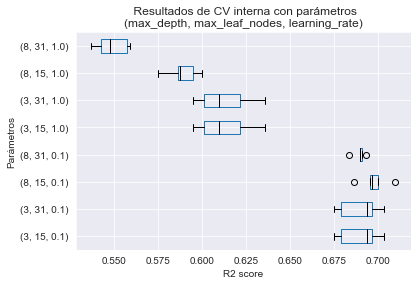

In [97]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parámetros")
_ = plt.title(" Resultados de CV interna con parámetros\n"
              "(max_depth, max_leaf_nodes, learning_rate)")

Vemos que los primeros 4 conjuntos de parámetros clasificados están muy cercanos. Podríamos seleccionar cualquier de esas 4 combinaciones. Coincide con los resultados que observamos inspeccionando los mejor parámetros de la validación cruzada externa.

# Ejercicio

Vamos a poner en práctica lo aprendido en este post con un ejercicio. Para ellos usaremos el dataset de pingüinos, pero no usaremos el objetivo tradicional de predecir la especie.

In [98]:
import pandas as pd

df = pd.read_csv("../data/penguins.csv")

feature_names = [
    "Culmen Length (mm)",
    "Culmen Depth (mm)",
    "Flipper Length (mm)",
]
target_name = "Body Mass (g)"

df = df[feature_names + [target_name]].dropna(axis="rows", how="any")
df = df.sample(frac=1, random_state=0).reset_index(drop=True)
X, y = df[feature_names], df[target_name]

El objetivo es predicir la masa corporal (`Body Mass (g)`) de un pingüino, dadas sus medidas de pico y aleta. Por lo tanto, se trata de un problema de regresión.

Véase que hemos mezclado aleatoriamente las filas del dataset después de cargarlo (`df.sample(frac=1, random_state=0)`). La razón es romper una dependencia estadística espúrea relacionada con el orden que pudiera causar problemas con el procedimiento simple de validación cruzada que usamos en este post. Evaluaremos los siguientes modelos basados en árboles:

+ un árbol de decisión regresor, es decir, `sklearn.tree.DecisionTreeRegressor`
+ un random forest regresor, e decir, `sklearn.ensemble.RandomForestRegressor`

Usaremos las configuraciones por defecto de hiperparámetros para ambos modelos. Tenemos que evaluar el rendimiento de generalización de dichos modelos usando una validación cruzada de 10-particiones:

+ usaremos `sklearn.model_selection.cross_validate` para ejecutar la rutina de validación cruzada
+ establecermos el parámetro `cv=10` para usar una estrategia de validaciónc cruzada de 10-particiones. Almacenaremos la puntuación de entrenamiento de validación cruzada estableciendo el parámetro `return_train_score=True` en la función `cross_validate`

**Comparando las puntuaciones de prueba de validación cruzada partición a partición, cuenta el número de veces que un random forest es mejor que un único árbol de decisión.**

In [99]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

cv=10
tree = DecisionTreeRegressor(random_state=0)
random_forest = RandomForestRegressor(random_state=0)

scores_tree = cross_validate(tree, X, y, cv=cv, return_train_score=True,
                             n_jobs=-1)

scores_random_forest = cross_validate(random_forest, X, y, cv=cv,
                                      return_train_score=True, n_jobs=-1)

In [100]:
scores_tree["test_score"].mean(), scores_tree["test_score"].std()

(0.6274987889886428, 0.099704183300966)

In [101]:
scores_random_forest["test_score"].mean(), scores_random_forest["test_score"].std()

(0.8035860871438268, 0.04467350184659844)

In [102]:
scores_random_forest["test_score"] > scores_tree["test_score"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [103]:
print(f"Random forest es mejor que un árbol de decisión en "
      f"{sum(scores_random_forest['test_score'] > scores_tree['test_score'])} "
      f"iteraciones de {cv}")

Random forest es mejor que un árbol de decisión en 10 iteraciones de 10


Ahora vamos a entrenar y evaluar con la misma estrategia de validación cruzada un random forest con 5 árboles de decisión y otro que contenga 100 árboles de decisión. También almacenaremos la puntuación de entrenamiento.

**Comparando las puntuaciones de test partición a partición, cuenta el número de veces que un random forest con 100 árboles de decisión es mejor que un árbol de decisión con 5 árboles decisión.**

In [104]:
random_forest_5 = RandomForestRegressor(n_estimators=5, random_state=0)
random_forest_100 = RandomForestRegressor(n_estimators=100, random_state=0)

scores_rf_5 = cross_validate(random_forest_5, X, y, cv=cv,
                                      return_train_score=True,
                                      n_jobs=-1)
scores_rf_100 = cross_validate(random_forest_100, X, y, cv=cv,
                                      return_train_score=True,
                                      n_jobs=-1)

In [105]:
scores_rf_5["test_score"].mean(), scores_rf_5["test_score"].std()

(0.7668640137103877, 0.07359278138744398)

In [106]:
scores_rf_100["test_score"].mean(), scores_rf_100["test_score"].std()

(0.8035860871438268, 0.04467350184659844)

In [107]:
print(f"Random forest (100) es mejor que un random forest (5) en "
      f"{sum(scores_rf_100['test_score'] > scores_rf_5['test_score'])} "
      f"iteraciones de {cv}")

Random forest (100) es mejor que un random forest (5) en 9 iteraciones de 10


Añadir árboles al bosque ayuda a mejorar el rendimiento de generalización del modelo. Podemos obtener algún conocimiento adicional comparando las puntuaciones de prueba y entrenamiento de cada modelo:

In [108]:
print(f"Puntuaciones para random forest con 5 árboles: \n"
      f" Entrenamiento: "
      f"{scores_rf_5['train_score'].mean():.3f} +/- "
      f"{scores_rf_5['train_score'].std():.3f}\n"
      f" Prueba       : "
      f"{scores_rf_5['test_score'].mean():.3f} +/- "
      f"{scores_rf_5['test_score'].std():.3f}\n")

print(f"Puntuaciones para random forest con 100 árboles: \n"
      f" Entrenamiento: "
      f"{scores_rf_100['train_score'].mean():.3f} +/- "
      f"{scores_rf_100['train_score'].std():.3f}\n"
      f" Prueba       : "
      f"{scores_rf_100['test_score'].mean():.3f} +/- "
      f"{scores_rf_100['test_score'].std():.3f}\n")

Puntuaciones para random forest con 5 árboles: 
 Entrenamiento: 0.950 +/- 0.003
 Prueba       : 0.767 +/- 0.074

Puntuaciones para random forest con 100 árboles: 
 Entrenamiento: 0.972 +/- 0.001
 Prueba       : 0.804 +/- 0.045



En el modelo con 5 árboles, la puntuación media de entrenamiento ya era bastante alta pero la puntuación media de prueba es bastante baja. El rendimiento de este random forest pequeño está limitado, por tanto, por el overfitting.

En el bosque con 100 árboles, la puntuación de entrenamiento sigue siendo alta (incluso ligeramente más alta), y la puntuación de prueba se ha reducido. El overfitting se ha reducido añadiendo más árboles al bosque.

**Dibuja la curva de estimación de los parámetros `n_estimators` definidos por `n_estimators = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]`**

In [109]:
from sklearn.model_selection import validation_curve

rf = RandomForestRegressor(random_state=0)

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]

rf_train_scores, rf_test_scores = validation_curve(
    rf, X, y,
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=-1
)

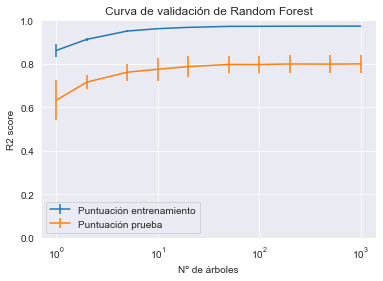

In [110]:
import matplotlib.pyplot as plt

plt.errorbar(
    param_range,
    rf_train_scores.mean(axis=1),
    yerr=rf_train_scores.std(axis=1),
    label="Puntuación entrenamiento",
)
plt.errorbar(
    param_range,
    rf_test_scores.mean(axis=1),
    yerr=rf_test_scores.std(axis=1),
    label="Puntuación prueba",
)
plt.legend()
plt.xscale("log")
plt.xlabel("Nº de árboles")
plt.ylabel("R2 score")
plt.ylim([0, 1])
_ = plt.title("Curva de validación de Random Forest")

Repite el experimento previo pero esta vez, en lugar de elegir los parámetros por defecto para random forest, establece el parámetro `max_depth=5` y contruye la curva de validación.

**Comparando la curva de validación (entrenamiento y prueba) del random forest con profundidad total y el random forest con la profundidad limitada, ¿Qué conclusiones se pueden obtener?**

In [111]:
rf_5 = RandomForestRegressor(max_depth=5, random_state=0)

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]

rf_5_train_scores, rf_5_test_scores = validation_curve(
    rf_5, X, y,
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=-1
)

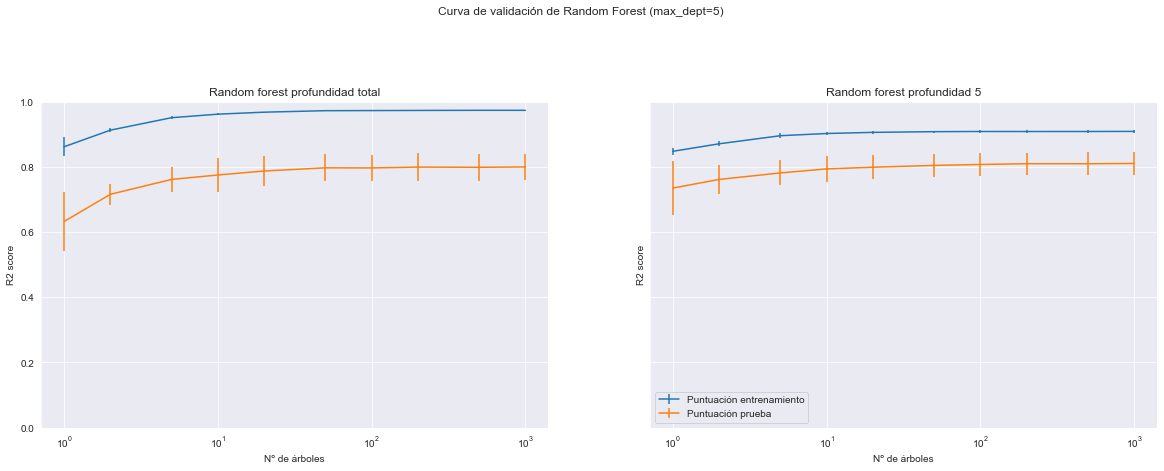

In [112]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 6))

axs[0].errorbar(
    param_range,
    rf_train_scores.mean(axis=1),
    yerr=rf_train_scores.std(axis=1),
    label="Puntuación entrenamiento",
)
axs[0].errorbar(
    param_range,
    rf_test_scores.mean(axis=1),
    yerr=rf_test_scores.std(axis=1),
    label="Puntuación prueba",
)
axs[0].set_title("Random forest profundidad total")
axs[0].set_xscale("log")
axs[0].set_xlabel("Nº de árboles")
axs[0].set_ylabel("R2 score")
axs[0].set_ylim([0, 1])

axs[1].errorbar(
    param_range,
    rf_5_train_scores.mean(axis=1),
    yerr=rf_5_train_scores.std(axis=1),
    label="Puntuación entrenamiento",
)
axs[1].errorbar(
    param_range,
    rf_5_test_scores.mean(axis=1),
    yerr=rf_5_test_scores.std(axis=1),
    label="Puntuación prueba",
)
axs[1].set_title("Random forest profundidad 5")
axs[1].set_xscale("log")
axs[1].set_xlabel("Nº de árboles")
axs[1].set_ylabel("R2 score")
axs[1].set_ylim([0, 1])
plt.legend()
_ = fig.suptitle("Curva de validación de Random Forest (max_dept=5)", y=1.1)

La puntuación de entrenamiento del random forest con profundidad total es casi siempre mejor que la puntuación de entrenamiento del random forest con una profundidad limitada. La diferencia entre las puntuaciones de entrenamiento y prueba disminuye cuando se reduce la profundidad de los árboles del random forest.

También observamos que el random forest con profundidad limitada tiene un mejor rendimiento de generalización para un pequeño número de árboles pero que es equivalente para un número alto de árboles. Podemos concluir que los modelos random forest con una profundidad limitada de árboles tienen menos overfitting que los random forest con árboles totalmente desarrollados, especialmente cuando el número de árboles del conjunto es pequeño.

También observamos que limitar la profundidad tiene un efecto significativo en la limitación de la puntuación de entrenamiento (habilidad para memorizar exactamente los datos de entrenamiento) y que este efecto sigue siendo importante incluso cuando se aumenta el tamaño del conjunto.

Vamos a centrarnos ahora en el principio de las curvas de validación y a considerar la puntuación de entrenamiento de un random forest con un único árbol mientras usamos la configuración del parámetro por defecto `max_depth=None`:

In [113]:
rf_1_tree = RandomForestRegressor(n_estimators=1, random_state=0)
cv_results_tree = cross_validate(
    rf_1_tree, X, y, cv=10, return_train_score=True
)
cv_results_tree["train_score"]

array([0.83120264, 0.83309064, 0.83195043, 0.84834224, 0.85790323,
       0.86235297, 0.84791111, 0.85183089, 0.82241954, 0.85045978])

El hecho de que este random forest de un único árbol nunca pueda alcanzar la puntuación perfecta R2 de 1.0 en el entrenamiento puede ser sorprendente. De hecho, si evaluamos la precisión de entrenamiento del único `DecissionTreeRegressor` se obtiene una perfecta memorización de los datos de entrenamiento:

In [114]:
tree = DecisionTreeRegressor(random_state=0)
cv_results_tree = cross_validate(
    tree, X, y, cv=10, return_train_score=True
)
cv_results_tree["train_score"]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

**¿Cómo se explica que un random forest de un único árbol no pueda alcanzar la puntuación perfecta de entrenamiento?**

La respuesta es que el único árbol del random forest se entrena usando bootstrap en el conjunto de entrenamiento y no el conjunto de entrenamiento en sí mismo (porque `bootstrap = True` por defecto).

Por defecto, random forest entrena los árboles con el procedimiento de bootstrapping. Dado que cada árbol es entrenado en una muestra bootstrap, algunos puntos de datos del conjunto de entrenamiento original no son vistos por árboles individuales en el bosque. Como resultado, el único árbol del modelo random forest no hace predicciones perfectas en esos puntos (denominados muestras out-of-bag), lo cual previene que la puntuación de entrenamiento alcance 1.0.

Podemos confirmar esta hipótesis desactivando la opción bootstrap y comprobando de nuevo las puntuaciones de entrenamiento (dejando resto de hiperparámetros inalterados):

In [115]:
rf_1_tree = RandomForestRegressor(n_estimators=1,
                                  bootstrap=False,
                                  random_state=0)
cv_results_tree = cross_validate(
    rf_1_tree, X, y, cv=10, return_train_score=True
)
cv_results_tree["train_score"]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

En este caso, recurrimos al mismo algoritmo que el árbol de decisión único, entrenandolo en los datos originales y, por tanto, generando overfitting en el dataset de entrenamiento original.

También podemos advertir que cuando se incrementa el número de árboles a 5 ó 10, el entrenamiento sub-óptimo causado por bootstrapping se desvanece rápidamente. Los random forest son entrenados con al menos 10 árboles y, típicamente, muchos más que esos, así este efecto casi no se observa en la práctica.

Además, incluso con un único árbol con bootstrapping, una puntuación de R2 mayor que 0.85 todavía es muy alta y, típicamente, mucho mayor que la puntuación de prueba del mismo modelo. Como resultado, incluso si la puntuación de entrenamiento de este modelo no es perfecta, no se puede concluir que el rendimiento de generalización de un random forest con un único árbol está limitado por el underfitting. En cambio, los modelos de árboles únicos normalmente están limitados por overfitting cuando la profundidad no está limitada.

Construye una curva de validación para un `sklearn.ensemble.HistGradientBoostingRegressor`, variando `max_iter` como sigue:

`max_iter = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]`

Recordemos que `max_iter` corresponde con el número de árboles en los modelos boosting.

**Dibuja las puntuaciones medias de entrenamiento y prueba para cada valor de `max_iter`**.

In [116]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor(random_state=0)

param_range = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1_000]

hgbr_train_scores, hgbr_test_scores = validation_curve(
    hgbr, X, y,
    param_name="max_iter",
    param_range=param_range,
    n_jobs=-1
)

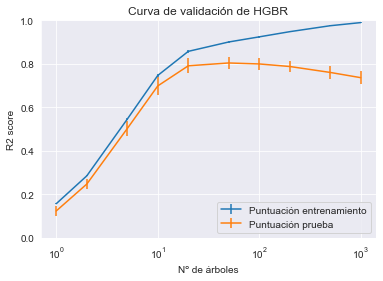

In [117]:
plt.errorbar(
    param_range,
    hgbr_train_scores.mean(axis=1),
    yerr=hgbr_train_scores.std(axis=1),
    label="Puntuación entrenamiento",
)
plt.errorbar(
    param_range,
    hgbr_test_scores.mean(axis=1),
    yerr=hgbr_test_scores.std(axis=1),
    label="Puntuación prueba",
)
plt.legend()
plt.xscale("log")
plt.xlabel("Nº de árboles")
plt.ylabel("R2 score")
plt.ylim([0, 1])
_ = plt.title("Curva de validación de HGBR")

En la gráfica podemos observar claramente las tres fases del comportamiento "undefitting / mejor generalización / overfitting" de los modelos gradient boosting. Con un número bajo de árboles, el modelo tiene una puntuaciones bajas tanto para el entrenamiento como en la prueba. Podemos ver claramente que la puntuación de prueba está limitada por la puntuación de entrenamiento, que es una característica de los modelos con underfitting (contrariamente a lo observado anteriormente en la curva de aprendizaje de los modelos random forest).

Ambas puntuaciones mejoran hasta alcanzar un punto dulce (alrededor de 50 árboles) donde la puntuación de prueba es máxima. Después de esto, el algoritmo de gradient boosting empieza con overfitting: la puntuación de entrenamiento mejora hasta alcanzar una puntuación perfecta de 1.0, mientras que la puntuación de prueba se reduce. De hecho, el modelo empieza a memorizar reglas específicas que solo se cumplen en el conjunto de entrenamiento. Estas reglas aprendidas van en detrimento del rendimiento de generalización del modelo.

Aquí se mumestra la importancia de no añadir demasiados árboles a nuestro conjunto de gradient boosting. De hecho, podemos usar parada temprana y monitorizar el rendimiento en un conjunto de validación interno para detener la adición de nuevos árboles cuando la puntuación de validación no mejore. Este es un ejemplo que muestra cómo hacer esto de forma automática:

In [118]:
hgbdt = HistGradientBoostingRegressor(early_stopping=True, random_state=0)
cv_results_hgbdt = cross_validate(
    hgbdt, X, y, cv=cv, return_train_score=True, return_estimator=True
)
cv_results_hgbdt["train_score"].mean(), cv_results_hgbdt["train_score"].std()

(0.8802093174685013, 0.009772033922083758)

VEmos que la puntuación de entrenamiento no es perfecta, lo que significa que nuestro modelo se ha detenido mucho antes de añadir demasiados árboles. Podemos comprobar el rendimiento de generalización para asegurar que es un modelo equivalente al random forest previo:

In [119]:
cv_results_hgbdt["test_score"].mean(), cv_results_hgbdt["test_score"].std()

(0.8075456252855009, 0.030400979794505564)

Observamos que, de media, el rendimiento del modelo es tan bueno como un gran random forest. Por último, podemos comprobar cuántos árboles ha usado por cada iteración de validación cruzada:

In [120]:
for idx, est in enumerate(cv_results_hgbdt["estimator"]):
    print(
        f"Para la iteración CV {idx + 1}, se han construido {est.n_iter_} árboles"
    )

Para la iteración CV 1, se han construido 60 árboles
Para la iteración CV 2, se han construido 50 árboles
Para la iteración CV 3, se han construido 46 árboles
Para la iteración CV 4, se han construido 29 árboles
Para la iteración CV 5, se han construido 33 árboles
Para la iteración CV 6, se han construido 33 árboles
Para la iteración CV 7, se han construido 36 árboles
Para la iteración CV 8, se han construido 31 árboles
Para la iteración CV 9, se han construido 24 árboles
Para la iteración CV 10, se han construido 23 árboles


Por lo tanto, vemos que nunca usamos más de 60 árboles, antes de entrar en la zona de overfitting que observamos en la curva de validación.

Incluso si este modelo no es tan fuerte como un gran random forest, es más pequeño lo que significa que puede ser más rápido para predecir y usará menos memoria (RAM) en las máquinas donde se despliegue. Esta es una vengja práctica de los árboles gradient boosting con parada temprana sobre random forest con una gran número de profundidad de árboles.

# Resumen

En este post hemos discutido los predictores de conjunto, que son un tipo de predictores que combinan predictores más simples juntos. Hemos visto dos estrategias:

+ una basada en muestras bootstrap que permite a los predictores ser entrenados en paralelo;
+ la otra llamada boosting que entrena los predictores secuencialmente.

De estas dos familias nos hemos enfocado principalmente en proporcionar intuiciones sobre la maquinaria interna los modelos de random forest y gradient-boosting, los cuales son métodos de última generación.

Algunas referencias a seguir con ejemplos de algunos conceptos mencionados:

+ [Parada temprana en gradient boosting](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-early-stopping-py)
+ [Combinación de predictores usando stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py)